# Calculate and plot the number of exchanged messages over time

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Global variables

In [3]:
pd.set_option("display.precision", 10)
pd.set_option('display.max_rows', 500)

timeframe_upper_limit = 60 # Seconds after startup that you want to look at

### Add path to the dict, use number of nodes as key
It will:
- collect all runs 
- use the key as groupby-column

In [4]:
paths =	[
  "../../logs/movement/02-04-2021"
]

exclude_paths = ["faulty"]

num_nodes = 73
height = 2
degree = 8

num_runs = {}

In [5]:
def update_num_runs(topo_run):
    res = {}
    for elem in topo_run:
        if elem[0] in res:
            res[elem[0]] += 1    
        else:
            res[elem[0]] = 1
    
    return res

In [6]:
# m_xxx = maintenance_xxx
# d_xxx = data_xxx
m_stamps = []
m_topologies = []
m_node_ids = []
m_runs = []
m_connect_outliers = []
m_num_movers = []

d_stamps = []
d_topologies = []
d_node_ids = []
d_runs = []

startup_times = {}

movers_run = []

for path in paths : 
    #print(path)
    for root, dirs, files in os.walk(path) :
        dirs[:] = [directory for directory in dirs if directory not in exclude_paths]
        # print(root)
        # print(dirs)
        # print(files)
        for file in files :
            with open( os.path.join(root, file) ) as log :   
                run = int(root.split('_')[-3])
                topology = num_nodes
                num_movers = int(root.split('_')[-1])
                node_id = int(file.split('_')[0][4:])                

                connect_attempts = 0  

                if (num_movers, run) not in movers_run:
                    movers_run.append((num_movers, run))

                for line in log :            
                    if "RECEIVED MESSAGE" in line:
                        # maintencance messages 
                        elem = line.split( )                
                        m_node_ids.append(int(node_id))                        
                        m_stamps.append( int(elem[8]) ) # unix timestamp
                        m_topologies.append(topology)
                        m_runs.append(run)
                        m_num_movers.append(num_movers)
                    
                    elif "DATA RECEIVED" in line:
                        # data messages
                        pass
                    elif "STARTUP TIME" in line:
                        elem = line.split( )
                        startup_times[num_movers, run] = int(elem[-1])
                    elif "Try to connect" in line:
                        connect_attempts += 1
                
                if (connect_attempts > 5):
                    m_connect_outliers.append("run " + run + " node " + node_id)

m_data = pd.DataFrame(np.column_stack([m_topologies, m_runs, m_node_ids, m_num_movers, m_stamps]), columns=['topology', 'run', 'node_id', 'number of movers', 'timestamp'])
# print(startup_time)
m_data

,topology,run,node_id,number of movers,timestamp
0,73,4,29,1,1617307541804448629
1,73,4,29,1,1617307541804608437
2,73,4,29,1,1617307541804637444
3,73,4,29,1,1617307541804669946
4,73,4,29,1,1617307541997468646
...,...,...,...,...,...
78198,73,10,23,1,1617309459398569413
78199,73,10,23,1,1617309462321099468
78200,73,10,23,1,1617309462321271184
78201,73,10,23,1,1617309477621414910


In [7]:
movers_run

[(1, 4),
 (7, 1),
 (7, 4),
 (7, 8),
 (1, 7),
 (1, 6),
 (1, 9),
 (7, 7),
 (7, 3),
 (1, 3),
 (1, 2),
 (1, 5),
 (1, 0),
 (1, 8),
 (1, 10)]

In [8]:
num_runs = update_num_runs(movers_run)
num_runs

{1: 10, 7: 5}

In [9]:
m_data['timestamp'] = m_data.apply(lambda row: row.timestamp - startup_times[(row['number of movers'], row.run)], axis=1)
m_data['timestamp_sec'] = m_data['timestamp'].apply(lambda x: x // 1000000000)
m_data

,topology,run,node_id,number of movers,timestamp,timestamp_sec
0,73,4,29,1,2924006664,2
1,73,4,29,1,2924166472,2
2,73,4,29,1,2924195479,2
3,73,4,29,1,2924227981,2
4,73,4,29,1,3117026681,3
...,...,...,...,...,...,...
78198,73,10,23,1,32645652790,32
78199,73,10,23,1,35568182845,35
78200,73,10,23,1,35568354561,35
78201,73,10,23,1,50868498287,50


# Reduce timeframe

In [10]:
m_data = m_data[m_data.timestamp_sec <= timeframe_upper_limit]
m_data

,topology,run,node_id,number of movers,timestamp,timestamp_sec
0,73,4,29,1,2924006664,2
1,73,4,29,1,2924166472,2
2,73,4,29,1,2924195479,2
3,73,4,29,1,2924227981,2
4,73,4,29,1,3117026681,3
...,...,...,...,...,...,...
78198,73,10,23,1,32645652790,32
78199,73,10,23,1,35568182845,35
78200,73,10,23,1,35568354561,35
78201,73,10,23,1,50868498287,50


# Try to find outliers

In [11]:
m_outliers = m_data.groupby(['topology', 'run', 'node_id', 'number of movers', 'timestamp_sec']).size().reset_index(name='number of messages').sort_values(by=['number of messages'], ascending=False, axis=0)
#m_outliers.head()

# Compute results

In [12]:
m_grouped = m_data.groupby(['topology', 'number of movers', 'timestamp_sec']).size().reset_index(name='number of messages')
m_grouped['number of messages'] = m_grouped.apply(lambda row: row['number of messages'] / num_runs[row['number of movers']], axis=1)
m_grouped['number of messages per node'] = m_grouped.apply(lambda row: row['number of messages'] / row['topology'], axis=1)
m_grouped.head()

,topology,number of movers,timestamp_sec,number of messages,number of messages per node
0,73,1,0,19.0,0.2602739726
1,73,1,1,30.0,0.4109589041
2,73,1,2,159.4,2.1835616438
3,73,1,3,610.7,8.3657534247
4,73,1,4,250.0,3.4246575342


# Plot

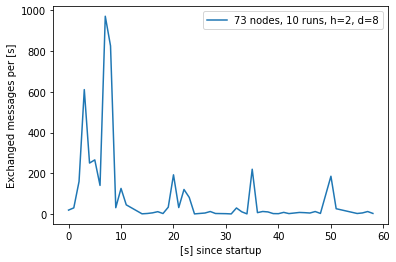

In [13]:
topo_to_plot = 73
num_movers_to_plot = 1

ax = plt.gca()

m_grouped[(m_grouped['topology'] == topo_to_plot) & (m_grouped['number of movers'] == num_movers_to_plot)].plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")

plt.legend([str(topo_to_plot) +' nodes, ' + str(num_runs[num_movers_to_plot]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
# plt.savefig('maintenance-paper-73.pdf')  

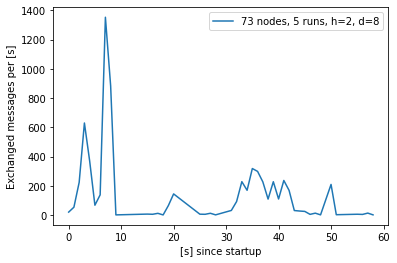

In [14]:
topo_to_plot = 73
num_movers_to_plot = 7

ax = plt.gca()

m_grouped[(m_grouped['topology'] == topo_to_plot) & (m_grouped['number of movers'] == num_movers_to_plot)].plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")

plt.legend([str(topo_to_plot) +' nodes, ' + str(num_runs[num_movers_to_plot]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
# plt.savefig('maintenance-paper-73.pdf')  

# Compute maxima etc.

In [15]:
m_agg_60 = m_grouped[m_grouped['timestamp_sec'] < 60].drop(columns=['timestamp_sec']).groupby(['topology', 'number of movers']).sum().reset_index()
m_agg_60['number of messages per second'] = m_agg_60['number of messages'].apply(lambda cell: cell / 60)
m_agg_60['number of messages per node per second'] = m_agg_60['number of messages per node'].apply(lambda cell: cell / 60)
m_agg_60

,topology,number of movers,number of messages,number of messages per node,number of messages per second,number of messages per node per second
0,73,1,4546.4,62.2794520548,75.7733333333,1.0379908676
1,73,7,6547.8,89.6958904110,109.1300000000,1.4949315068


In [16]:
print('Topology with the maximum number of messages:')
m_agg_60.loc[m_agg_60['number of messages'] == m_agg_60['number of messages'].max()]

Topology with the maximum number of messages:


,topology,number of movers,number of messages,number of messages per node,number of messages per second,number of messages per node per second
1,73,7,6547.8,89.695890411,109.13,1.4949315068


In [17]:
print('Topology with the maximum number of messages per node:')
m_agg_60.loc[m_agg_60['number of messages per node'] == m_agg_60['number of messages per node'].max()]

Topology with the maximum number of messages per node:


,topology,number of movers,number of messages,number of messages per node,number of messages per second,number of messages per node per second
1,73,7,6547.8,89.695890411,109.13,1.4949315068


# Numbers for movement experiment

In [18]:
# For comparision with movement scenario 
movement_comparison = m_grouped[(m_grouped['timestamp_sec'] >= 31) & (m_grouped['timestamp_sec'] <= 41)].groupby(['topology', 'number of movers'])['number of messages'].sum()
# movement_comparison

In [19]:
print('Messages exchanged between 31s,41s with 1 mover: ' + str(movement_comparison) + '\n')

Messages exchanged between 31s,41s with 1 mover: topology  number of movers
73        1                    301.0
          7                   2047.2
Name: number of messages, dtype: float64



In [20]:
print('Messages exchanged between 31s,41s per node: ' + str(movement_comparison / num_nodes))

Messages exchanged between 31s,41s per node: topology  number of movers
73        1                    4.1232876712
          7                   28.0438356164
Name: number of messages, dtype: float64


In [21]:
print('Messages exchanged between 31s,41s per node: ' + str(movement_comparison / (num_nodes * 11)))

Messages exchanged between 31s,41s per node: topology  number of movers
73        1                   0.3748443337
          7                   2.5494396015
Name: number of messages, dtype: float64
